In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Preprocessing:
+ Load and read the images and respective masks and save to Numpy Arrays.

In [2]:
import os
import numpy as np
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img, img_to_array

os.chdir('/content/drive/My Drive/GitHub Repositories/State of Art Segmentation Network Architectures')
imagesDir = './datasets/Chest X-rays/CXRs/Train'
masksDir = './datasets/Chest X-rays/Masks/Train'

imageNames = os.listdir(imagesDir)
maskNames = os.listdir(masksDir)
print('Training CXRS: {} | Training Masks: {}'.format(len(imageNames), len(maskNames)))

IMG_SIZE=256

images=[]
masks=[]

for imageName in tqdm(imageNames):
    image = load_img(os.path.join(imagesDir, imageName), color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE), interpolation='lanczos')
    image_array =  img_to_array(image, data_format='channels_last', dtype='float32')
    images.append(image_array)

    mask = np.asarray(load_img(os.path.join(masksDir, imageName), color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE), interpolation='lanczos'))
    mask_array =  img_to_array(mask, data_format='channels_last', dtype='float32')
    masks.append(mask_array)

images = np.asarray(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
masks = np.asarray(masks).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

np.save('./datasets/Chest X-rays/images.npy', images)
np.save('./datasets/Chest X-rays/masks.npy', masks)

print('Images and Masks are saved to Numpy Arrays in respective Directories')

Using TensorFlow backend.


Training CXRS: 704 | Training Masks: 704



Images and Masks are saved to Numpy Arrays in respective Directories


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, CSVLogger

Using TensorFlow backend.


In [3]:
os.chdir('/content/drive/My Drive/GitHub Repositories/State of Art Segmentation Network Architectures')
images = np.load('./datasets/Chest X-rays/images.npy')

# Z-score Normalization
mean = np.mean(images)
std = np.std(images)
images -= mean
images /= std


masks = np.load('./datasets/Chest X-rays/masks.npy')
# Normalize masks to [0, 1]
masks /= 255. 

print('Images: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(images.shape, images.dtype, np.amax(images), np.amin(images)))
print('Masks: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(masks.shape, masks.dtype, np.amax(masks), np.amin(masks)))

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.05, random_state=2020)
print('Train Images: {} | Train Masks: {}'.format(images_train.shape, masks_train.shape))
print('Validation Images: {} | Validation Masks: {}'.format(images_test.shape, masks_test.shape))

Images: (704, 256, 256, 1) | Dtype: float32 | Max-Val: 1.4874210357666016 | Min-Val: -2.0686044692993164
Masks: (704, 256, 256, 1) | Dtype: float32 | Max-Val: 1.0 | Min-Val: 0.0
Train Images: (668, 256, 256, 1) | Train Masks: (668, 256, 256, 1)
Validation Images: (36, 256, 256, 1) | Validation Masks: (36, 256, 256, 1)


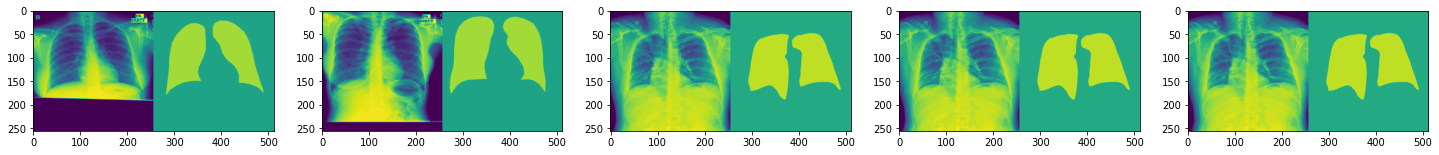

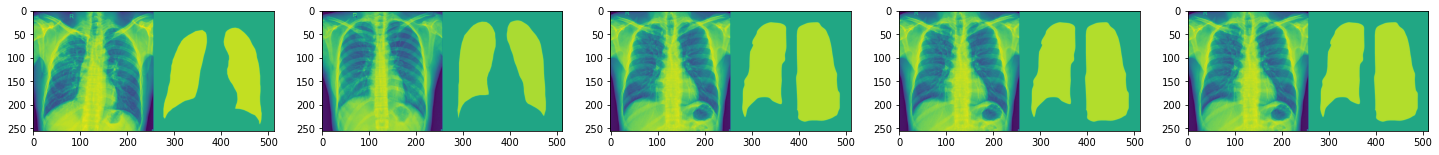

In [4]:
import matplotlib.pyplot as plt

def plotMask(images, masks):
    sample = []
    for i in range(10):
        left = images[i, :, :, 0]
        right = masks[i, :, :, 0]
        combined = np.hstack((left,right))
        sample.append(combined)
        
    for i in range(0, 10, 5):
        plt.figure(figsize=(25,10))
        
        plt.subplot(2, 5, 1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2, 5, 2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2, 5, 3+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 4+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 5+i)
        plt.imshow(sample[i+2])
        
        plt.show()

plotMask(images_test, masks_test)

In [7]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


IMG_SIZE = 256
smooth=1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
        how many relevant items are selected. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
        how many selected items are relevant. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1score =  2 * ((precision * recall) / (precision + recall))
    return f1score

def UNET_Architecture():
    inputs = Input((IMG_SIZE, IMG_SIZE, 1))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

model = UNET_Architecture()
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, 'accuracy', precision, recall, f1score])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________




Train on 668 samples, validate on 36 samples
Epoch 1/100





668/668 [==============================] - 25s 37ms/step - loss: -0.3371 - dice_coef: 0.3371 - acc: 0.6930 - precision: 0.4132 - recall: 0.3497 - f1score: 0.3690 - val_loss: -0.3391 - val_dice_coef: 0.3391 - val_acc: 0.6555 - val_precision: 0.3889 - val_recall: 0.5300 - val_f1score: 0.4486

Epoch 00001: val_acc improved from -inf to 0.65547, saving model to ./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5
Prediction Results at epoch: 1 are below


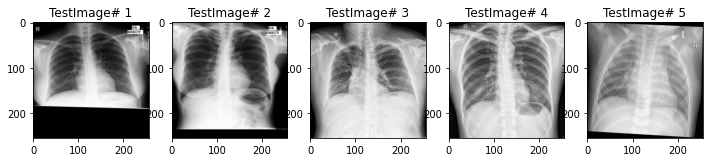

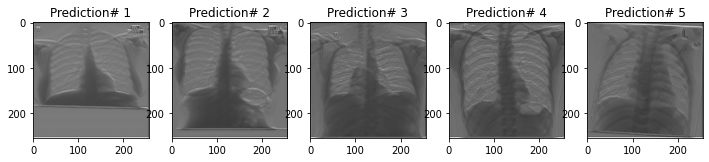

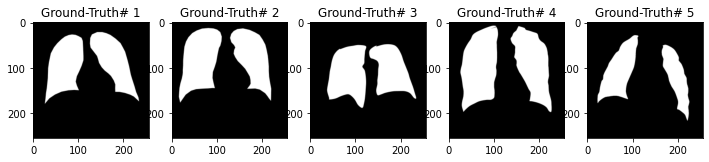

Epoch 2/100
668/668 [==============================] - 6s 9ms/step - loss: -0.3385 - dice_coef: 0.3385 - acc: 0.6447 - precision: 0.3892 - recall: 0.6198 - f1score: 0.4776 - val_loss: -0.3407 - val_dice_coef: 0.3407 - val_acc: 0.6446 - val_precision: 0.3997 - val_recall: 0.6801 - val_f1score: 0.5034

Epoch 00002: val_acc did not improve from 0.65547
Epoch 3/100
668/668 [==============================] - 6s 9ms/step - loss: -0.3401 - dice_coef: 0.3401 - acc: 0.6461 - precision: 0.4011 - recall: 0.6946 - f1score: 0.5082 - val_loss: -0.3424 - val_dice_coef: 0.3424 - val_acc: 0.6425 - val_precision: 0.4023 - val_recall: 0.7081 - val_f1score: 0.5130

Epoch 00003: val_acc did not improve from 0.65547
Epoch 4/100
668/668 [==============================] - 6s 9ms/step - loss: -0.3418 - dice_coef: 0.3418 - acc: 0.6421 - precision: 0.4018 - recall: 0.7171 - f1score: 0.5144 - val_loss: -0.3445 - val_dice_coef: 0.3445 - val_acc: 0.6360 - val_precision: 0.3991 - val_recall: 0.7232 - val_f1score: 0.

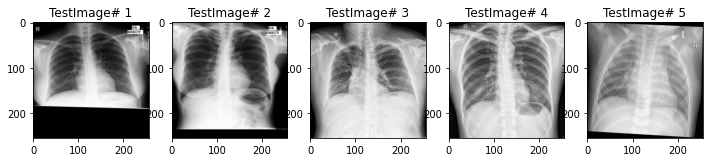

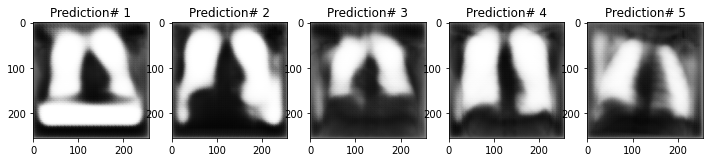

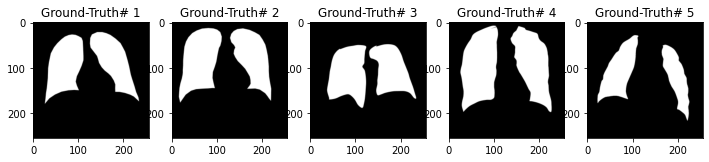

Epoch 12/100
668/668 [==============================] - 6s 9ms/step - loss: -0.7484 - dice_coef: 0.7484 - acc: 0.8837 - precision: 0.7954 - recall: 0.8578 - f1score: 0.8227 - val_loss: -0.7976 - val_dice_coef: 0.7976 - val_acc: 0.8835 - val_precision: 0.8304 - val_recall: 0.8048 - val_f1score: 0.8160

Epoch 00012: val_acc improved from 0.82644 to 0.88355, saving model to ./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5
Epoch 13/100
668/668 [==============================] - 6s 9ms/step - loss: -0.8264 - dice_coef: 0.8264 - acc: 0.8942 - precision: 0.8370 - recall: 0.8426 - f1score: 0.8378 - val_loss: -0.8239 - val_dice_coef: 0.8239 - val_acc: 0.8857 - val_precision: 0.7963 - val_recall: 0.8726 - val_f1score: 0.8317

Epoch 00013: val_acc improved from 0.88355 to 0.88570, saving model to ./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5
Epoch 14/100
668/668 [==============================] - 6s 9ms/step - loss: -0.8386 - dice_coef:

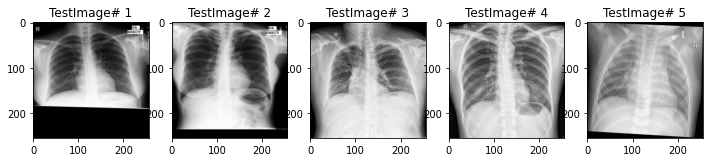

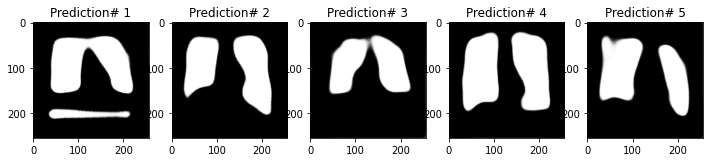

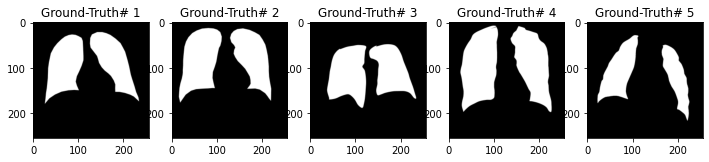

Epoch 22/100
668/668 [==============================] - 6s 9ms/step - loss: -0.8793 - dice_coef: 0.8793 - acc: 0.9158 - precision: 0.8857 - recall: 0.8800 - f1score: 0.8823 - val_loss: -0.8688 - val_dice_coef: 0.8688 - val_acc: 0.9116 - val_precision: 0.8976 - val_recall: 0.8484 - val_f1score: 0.8719

Epoch 00022: val_acc improved from 0.90905 to 0.91159, saving model to ./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5
Epoch 23/100
668/668 [==============================] - 6s 9ms/step - loss: -0.8823 - dice_coef: 0.8823 - acc: 0.9174 - precision: 0.8907 - recall: 0.8804 - f1score: 0.8852 - val_loss: -0.8711 - val_dice_coef: 0.8711 - val_acc: 0.9130 - val_precision: 0.9059 - val_recall: 0.8448 - val_f1score: 0.8739

Epoch 00023: val_acc improved from 0.91159 to 0.91295, saving model to ./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5
Epoch 24/100
668/668 [==============================] - 6s 9ms/step - loss: -0.8839 - dice_coef:

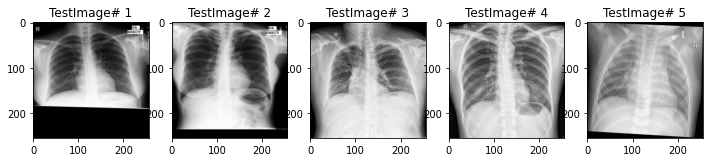

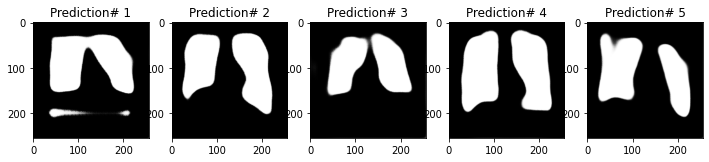

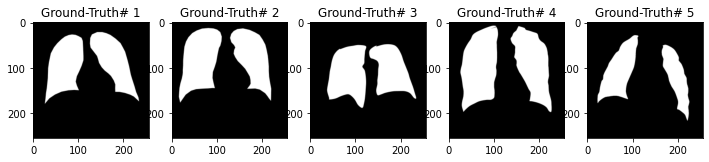

Epoch 32/100
668/668 [==============================] - 6s 9ms/step - loss: -0.8949 - dice_coef: 0.8949 - acc: 0.9225 - precision: 0.9010 - recall: 0.8941 - f1score: 0.8966 - val_loss: -0.8876 - val_dice_coef: 0.8876 - val_acc: 0.9200 - val_precision: 0.9151 - val_recall: 0.8655 - val_f1score: 0.8896

Epoch 00032: val_acc improved from 0.91905 to 0.91998, saving model to ./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5
Epoch 33/100
668/668 [==============================] - 6s 9ms/step - loss: -0.8994 - dice_coef: 0.8994 - acc: 0.9248 - precision: 0.9074 - recall: 0.8957 - f1score: 0.9011 - val_loss: -0.8834 - val_dice_coef: 0.8834 - val_acc: 0.9193 - val_precision: 0.9317 - val_recall: 0.8433 - val_f1score: 0.8853

Epoch 00033: val_acc did not improve from 0.91998
Epoch 34/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9007 - dice_coef: 0.9007 - acc: 0.9254 - precision: 0.9105 - recall: 0.8951 - f1score: 0.9023 - val_loss: -0.8944 - 

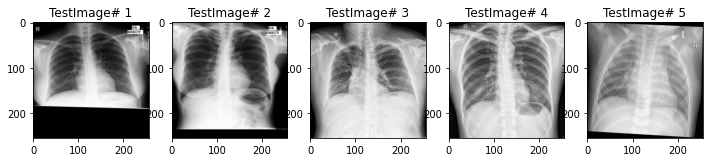

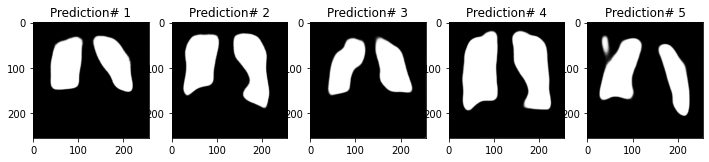

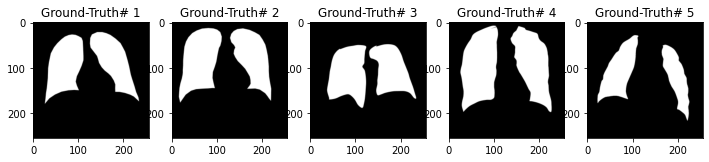

Epoch 42/100
668/668 [==============================] - 6s 9ms/step - loss: -0.8990 - dice_coef: 0.8990 - acc: 0.9241 - precision: 0.9054 - recall: 0.9005 - f1score: 0.9003 - val_loss: -0.8987 - val_dice_coef: 0.8987 - val_acc: 0.9251 - val_precision: 0.9370 - val_recall: 0.8656 - val_f1score: 0.8998

Epoch 00042: val_acc did not improve from 0.92603
Epoch 43/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9009 - dice_coef: 0.9009 - acc: 0.9252 - precision: 0.9116 - recall: 0.8968 - f1score: 0.9020 - val_loss: -0.9041 - val_dice_coef: 0.9041 - val_acc: 0.9263 - val_precision: 0.9165 - val_recall: 0.8948 - val_f1score: 0.9054

Epoch 00043: val_acc improved from 0.92603 to 0.92630, saving model to ./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5
Epoch 44/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9068 - dice_coef: 0.9068 - acc: 0.9279 - precision: 0.9159 - recall: 0.9023 - f1score: 0.9080 - val_loss: -0.8954 - 

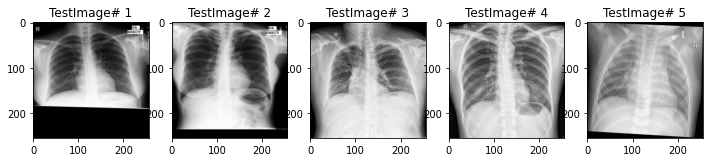

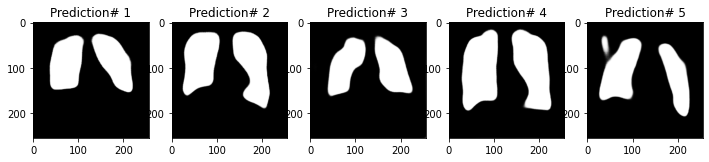

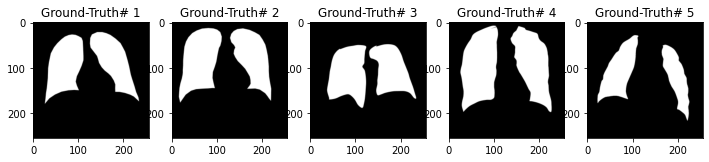

Epoch 52/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9189 - dice_coef: 0.9189 - acc: 0.9333 - precision: 0.9279 - recall: 0.9123 - f1score: 0.9200 - val_loss: -0.9133 - val_dice_coef: 0.9133 - val_acc: 0.9308 - val_precision: 0.9312 - val_recall: 0.8984 - val_f1score: 0.9145

Epoch 00052: val_acc improved from 0.93021 to 0.93078, saving model to ./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5
Epoch 53/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9165 - dice_coef: 0.9165 - acc: 0.9322 - precision: 0.9240 - recall: 0.9129 - f1score: 0.9176 - val_loss: -0.9128 - val_dice_coef: 0.9128 - val_acc: 0.9308 - val_precision: 0.9380 - val_recall: 0.8912 - val_f1score: 0.9140

Epoch 00053: val_acc improved from 0.93078 to 0.93084, saving model to ./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5
Epoch 54/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9159 - dice_coef:

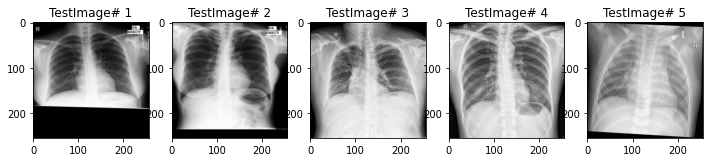

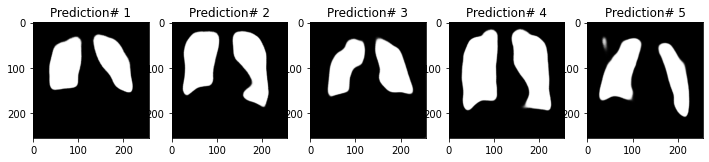

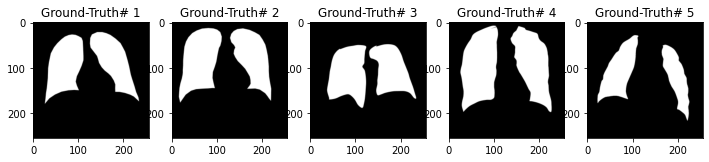

Epoch 62/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9209 - dice_coef: 0.9209 - acc: 0.9342 - precision: 0.9316 - recall: 0.9136 - f1score: 0.9219 - val_loss: -0.9191 - val_dice_coef: 0.9191 - val_acc: 0.9321 - val_precision: 0.9130 - val_recall: 0.9275 - val_f1score: 0.9202

Epoch 00062: val_acc did not improve from 0.93313
Epoch 63/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9137 - dice_coef: 0.9137 - acc: 0.9306 - precision: 0.9183 - recall: 0.9141 - f1score: 0.9145 - val_loss: -0.9158 - val_dice_coef: 0.9158 - val_acc: 0.9321 - val_precision: 0.9399 - val_recall: 0.8946 - val_f1score: 0.9167

Epoch 00063: val_acc did not improve from 0.93313
Epoch 64/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9214 - dice_coef: 0.9214 - acc: 0.9343 - precision: 0.9318 - recall: 0.9143 - f1score: 0.9223 - val_loss: -0.9197 - val_dice_coef: 0.9197 - val_acc: 0.9324 - val_precision: 0.9182 - val_recall: 0.9232 - val_f1score:

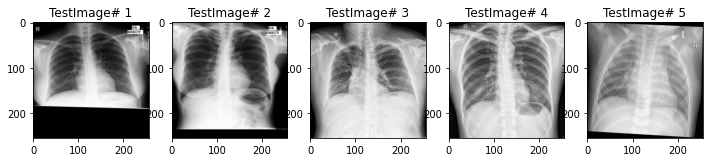

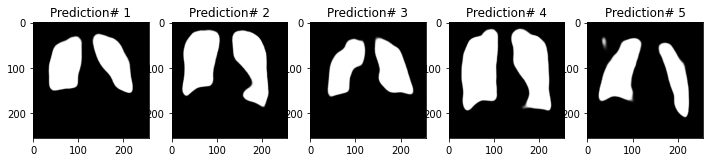

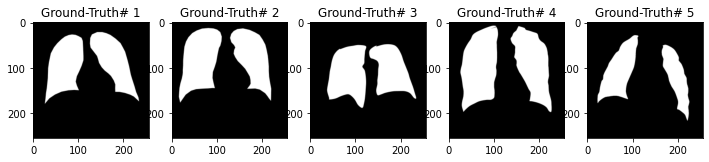

Epoch 72/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9286 - dice_coef: 0.9286 - acc: 0.9373 - precision: 0.9377 - recall: 0.9220 - f1score: 0.9295 - val_loss: -0.9240 - val_dice_coef: 0.9240 - val_acc: 0.9351 - val_precision: 0.9386 - val_recall: 0.9118 - val_f1score: 0.9250

Epoch 00072: val_acc improved from 0.93444 to 0.93507, saving model to ./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5
Epoch 73/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9280 - dice_coef: 0.9280 - acc: 0.9370 - precision: 0.9369 - recall: 0.9217 - f1score: 0.9289 - val_loss: -0.9224 - val_dice_coef: 0.9224 - val_acc: 0.9348 - val_precision: 0.9453 - val_recall: 0.9026 - val_f1score: 0.9234

Epoch 00073: val_acc did not improve from 0.93507
Epoch 74/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9291 - dice_coef: 0.9291 - acc: 0.9374 - precision: 0.9370 - recall: 0.9235 - f1score: 0.9299 - val_loss: -0.9196 - 

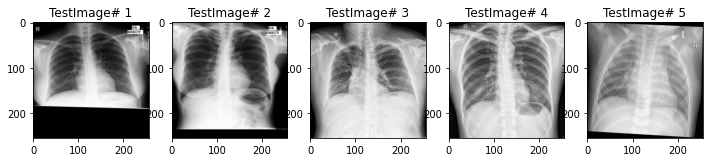

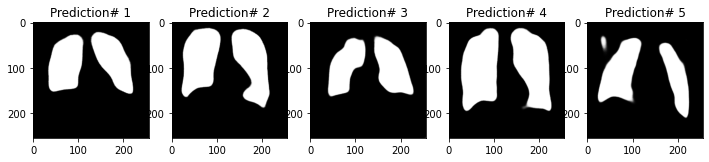

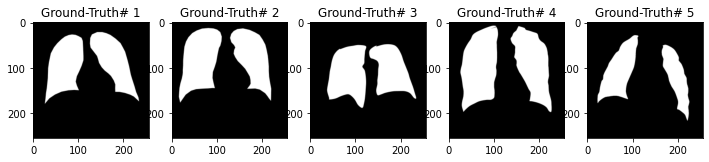

Epoch 82/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9309 - dice_coef: 0.9309 - acc: 0.9382 - precision: 0.9385 - recall: 0.9260 - f1score: 0.9317 - val_loss: -0.9135 - val_dice_coef: 0.9135 - val_acc: 0.9323 - val_precision: 0.9678 - val_recall: 0.8663 - val_f1score: 0.9141

Epoch 00082: val_acc did not improve from 0.93612
Epoch 83/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9320 - dice_coef: 0.9320 - acc: 0.9388 - precision: 0.9424 - recall: 0.9240 - f1score: 0.9328 - val_loss: -0.9266 - val_dice_coef: 0.9266 - val_acc: 0.9354 - val_precision: 0.9233 - val_recall: 0.9320 - val_f1score: 0.9276

Epoch 00083: val_acc did not improve from 0.93612
Epoch 84/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9328 - dice_coef: 0.9328 - acc: 0.9389 - precision: 0.9406 - recall: 0.9273 - f1score: 0.9336 - val_loss: -0.9228 - val_dice_coef: 0.9228 - val_acc: 0.9355 - val_precision: 0.9608 - val_recall: 0.8896 - val_f1score:

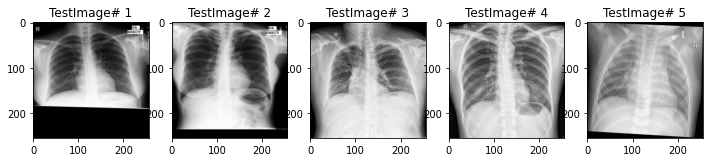

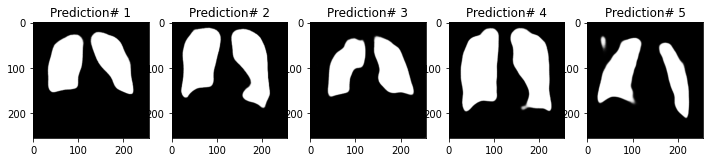

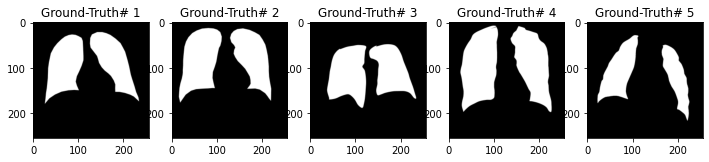

Epoch 92/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9360 - dice_coef: 0.9360 - acc: 0.9404 - precision: 0.9462 - recall: 0.9280 - f1score: 0.9368 - val_loss: -0.9251 - val_dice_coef: 0.9251 - val_acc: 0.9343 - val_precision: 0.9078 - val_recall: 0.9451 - val_f1score: 0.9261

Epoch 00092: val_acc did not improve from 0.93702
Epoch 93/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9353 - dice_coef: 0.9353 - acc: 0.9399 - precision: 0.9422 - recall: 0.9304 - f1score: 0.9360 - val_loss: -0.9306 - val_dice_coef: 0.9306 - val_acc: 0.9376 - val_precision: 0.9445 - val_recall: 0.9188 - val_f1score: 0.9314

Epoch 00093: val_acc improved from 0.93702 to 0.93760, saving model to ./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5
Epoch 94/100
668/668 [==============================] - 6s 9ms/step - loss: -0.9366 - dice_coef: 0.9366 - acc: 0.9405 - precision: 0.9460 - recall: 0.9293 - f1score: 0.9374 - val_loss: -0.9303 - 

In [8]:
class prediction_history(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (epoch+1) % 10 == 1:
      print('Prediction Results at epoch: {} are below'.format(epoch+1))
      self.pred = model.predict(images_test)
      plot_images(images_test, self.pred, masks_test)
        
def plot_images(images_test, pred, masks_test):
  plt.figure(1, figsize = (12, 12))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('TestImage# {}' .format(i+1))
    plt.imshow(images_test[i, :, :, 0], cmap='gray')
  plt.figure(2, figsize = (12, 12))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('Prediction# {}' .format(i+1))
    plt.imshow(pred[i, :, :, 0], cmap='gray')
  plt.figure(3, figsize = (12, 12))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('Ground-Truth# {}' .format(i+1))
    plt.imshow(masks_test[i, :, :, 0], cmap='gray')
  plt.show()
  plt.close()

predictions = prediction_history()
checkpoint = ModelCheckpoint('./saved Models/UNET Models/Lungs Segmentation from Chest X-rays/best-model.h5', verbose=1, monitor='val_acc',
                             save_best_only=True, mode='auto') 

model.fit(images_train, masks_train, batch_size=32, epochs=100, verbose=1, shuffle=True, validation_data = (images_test, masks_test),
          callbacks=[checkpoint, predictions])

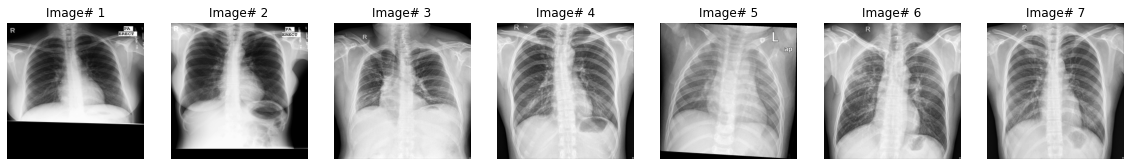

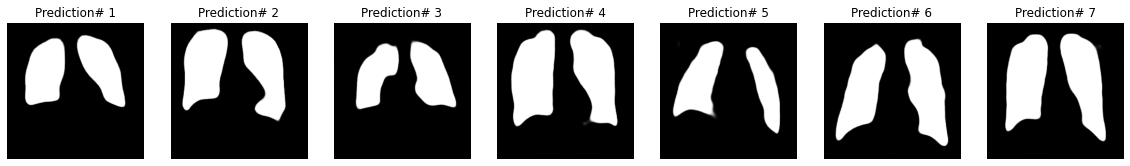

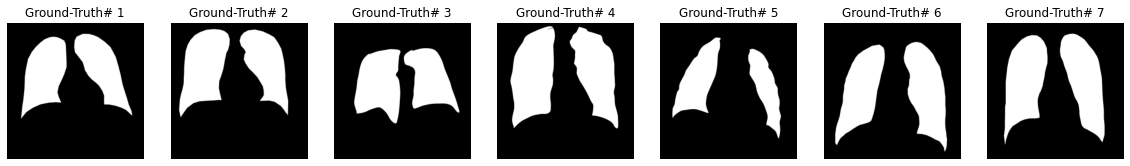

In [9]:
def plot_images(images_test, pred, masks_test):
  plt.figure(1, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Image# {}' .format(i+1))
    plt.imshow(images_test[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.figure(2, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Prediction# {}' .format(i+1))
    plt.imshow(pred[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.figure(3, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Ground-Truth# {}' .format(i+1))
    plt.imshow(masks_test[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.show()
  plt.close()

pred = model.predict(images_test)
plot_images(images_test, pred, masks_test)